# We are building models and forecast 30 days after for Continental Breakfast

We should first check the data and the trend:

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
import pandas as pd
import statsmodels.api as sm
import plotly.express as px

Import data, read the data and see the data descriptions.

In [ ]:
df = pd.read_excel("IMB465-XLS-ENG.xls")
df = df.rename(columns={'Continental B/F': 'Continental_BF', 'North Indian B/F': 'North_Indian_BF'})
print(df.info()) #information of the dataset
print(df.describe().round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             115 non-null    datetime64[ns]
 1   BKFST_OCCUP      115 non-null    int64         
 2   Idly             115 non-null    int64         
 3   Dosa             115 non-null    int64         
 4   Chutney          115 non-null    int64         
 5   Sambar           115 non-null    int64         
 6   Continental_BF   115 non-null    int64         
 7   North_Indian_BF  115 non-null    int64         
 8   Omellette        115 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 8.2 KB
None
       BKFST_OCCUP    Idly    Dosa  Chutney  Sambar  Continental_BF  \
count       115.00  115.00  115.00   115.00  115.00          115.00   
mean        215.16   59.27   25.48   131.34  131.47           41.30   
std          19.38    7.03   11.38    

Remodify the data with only the columns we need.

In [ ]:
df = df[['Date','Continental_BF']]
df.index = df.Date
df.index.freq = 'D'
df = df.drop('Date', axis = 1)

Show the data trend

In [ ]:
fig = px.line(x = df.index, y = df['Continental_BF'], labels = {'x':'Date', 'y': "Continental_BF"})
fig.show()

Plot the seasonality charts to check the seasonality.

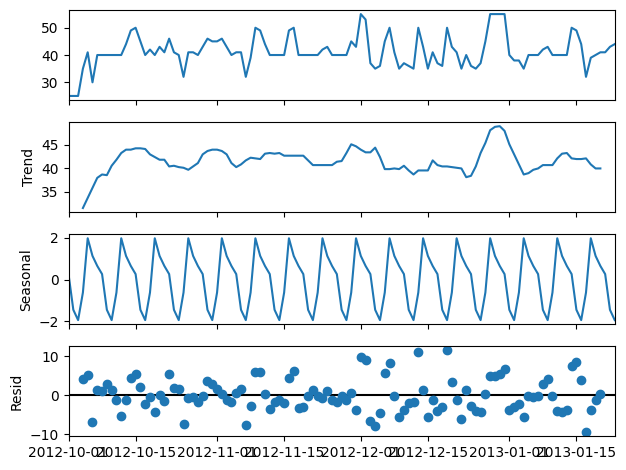

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(df, model="add")
decompose_data.plot();

## Moving Average

Moving average can show us the data trend more intuitively.

In [ ]:
PERIODS_AHEAD = 30
periods = 7
rolling_MA  = df.copy()
rolling_MA['MovingAverage'] = df.Continental_BF.rolling(periods).mean()
print(rolling_MA.head(14))
fig = px.line(rolling_MA, x = rolling_MA.index, y = ['Continental_BF', 'MovingAverage'],
              labels = {'value': 'Continental_BF', 'date':'Date','variable': 'Variable'})
fig.show()

            Continental_BF  MovingAverage
Date                                     
2012-10-01              25            NaN
2012-10-02              25            NaN
2012-10-03              25            NaN
2012-10-04              35            NaN
2012-10-05              41            NaN
2012-10-06              30            NaN
2012-10-07              40      31.571429
2012-10-08              40      33.714286
2012-10-09              40      35.857143
2012-10-10              40      38.000000
2012-10-11              40      38.714286
2012-10-12              40      38.571429
2012-10-13              44      40.571429
2012-10-14              49      41.857143


# The Forecasting Models

Now we start to build models.

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## ETS models

For the first 3 models, we use exponential smoothing models (sample, double-holt and triple-winter). We just use optimized = True to get the optimized solution for the models.

### Sample

In [ ]:
ets_model = SimpleExpSmoothing(df)
ets_fit = ets_model.fit(optimized=True)
# print(ets_fit.fittedvalues)

PERIODS_AHEAD = 30
fig = px.line(x = df.index, y = df['Continental_BF'], labels = {'x': 'Date', 'y':'Continental_BF'})
fig.add_scatter(x = ets_fit.fittedvalues.index, y = ets_fit.fittedvalues, name = 'Fitted Values')
fig.add_scatter(x = ets_fit.forecast(PERIODS_AHEAD).index, y = ets_fit.forecast(PERIODS_AHEAD), name = 'Forecast')
fig.show()

### Holt

In [ ]:
ets_model = ExponentialSmoothing(df, trend='add',
                    seasonal=None, initialization_method = 'estimated')
ets_fit = ets_model.fit(optimized = True)
forecast = ets_fit.forecast(PERIODS_AHEAD)
# print(forecast)

fig = px.line(x = df.index, y = df['Continental_BF'], labels = {'x': 'Date', 'y':'Demand'})
fig.add_scatter(x = ets_fit.fittedvalues.index, y = ets_fit.fittedvalues, name = 'Fitted Values')
fig.add_scatter(x = ets_fit.forecast(PERIODS_AHEAD).index, y = ets_fit.forecast(PERIODS_AHEAD), name = 'Forecast')
fig.show()

### Winter

In [ ]:
ets_model = ExponentialSmoothing(df, trend='add', seasonal='mul', seasonal_periods=7)
ets_fit = ets_model.fit(optimized=True)
forecast = ets_fit.forecast(PERIODS_AHEAD)
# print(ets_fit.forecast(PERIODS_AHEAD))

fig = px.line(x = df.index, y = df['Continental_BF'], labels = {'x': 'Date', 'y':'Demand'})
fig.add_scatter(x = ets_fit.fittedvalues.index, y = ets_fit.fittedvalues, name = 'Fitted Values')
fig.add_scatter(x = ets_fit.forecast(PERIODS_AHEAD).index, y = ets_fit.forecast(PERIODS_AHEAD), name = 'Forecast')
fig.show()


## ARIMA

## Check for stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df)

print(f'ADF Statistic {adf[0]}') # adf[0] - returns the ADF statistic value
print(f'p-value {adf[1]}') # adf[1] - returns the p-value -- if this value is high, the data is non-stationary


ADF Statistic -6.140300480128494
p-value 8.001298246056169e-08


## Explore autocorrelation

The plots help us determine what the parameter p and q should be.

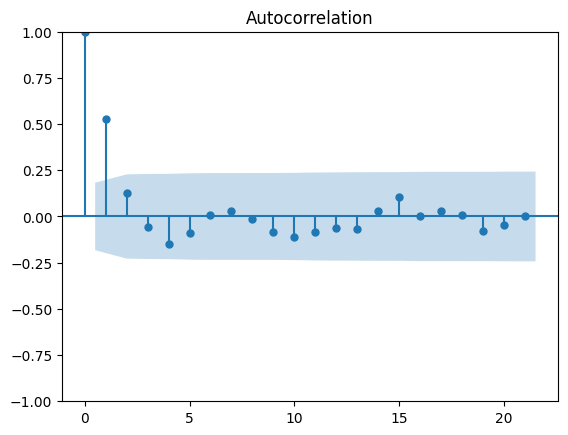

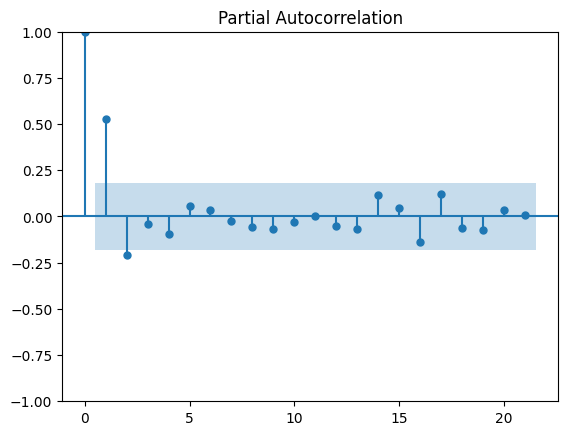

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
plot_acf(df).show() #q=1
plot_pacf(df).show() #p=1 or 2

## Search for the best ARIMA model using pmdarima

pmdarima automates the search for the best ARIMA model, it goes through many p,q,d combinations, and selects the model with the lowest AIC

In [ ]:
#install pmdarima package
!pip install pmdarima

In [ ]:
import pmdarima as pm

model_fit = pm.auto_arima(df,
                             start_p=1, start_q=1, start_d=1,
                             max_p=12, max_q=12, max_d=12,
                            seasonal= False, #since we already observed no seasonality in the data
                            error_action='ignore',
                            suppress_warnings=True,
                            trace = True,
                            stepwise = True,
                            stationary=True)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=692.761, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=733.400, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=695.003, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=694.928, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1186.400, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=694.217, Time=0.86 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=694.750, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=693.383, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=692.523, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=694.454, Time=0.66 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=696.514, Time=0.69 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 3.445 seconds
                               SARIMAX Results                                
Dep. Variable:          

# Result Validating (5 models)

In [ ]:
# Let us build a function that calculates MAPE to autmoate some steps further:
def calculate_mape(actual_values, predicted_values):
    return ((abs((actual_values - predicted_values) / actual_values))*100).mean()


We decide to split the train and test data by 0.9 : 0.1 (so we include new year days in our train data),  since we obseved **a big surge during New Year days,and this might affect our validation.**

In [ ]:
# Create a train and test sets:
train, test = df.iloc[:round(len(df) * 0.9)], df.iloc[round(len(df) * 0.9):]
print(len(test))
print(train.index) # dates in train data set

11
DatetimeIndex(['2012-10-01', '2012-10-02', '2012-10-03', '2012-10-04',
               '2012-10-05', '2012-10-06', '2012-10-07', '2012-10-08',
               '2012-10-09', '2012-10-10',
               ...
               '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06',
               '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10',
               '2013-01-11', '2013-01-12'],
              dtype='datetime64[ns]', name='Date', length=104, freq='D')


## Cross-validate the results (ARIMA)

In [ ]:
arima = pm.auto_arima(train,
                             start_p=1, start_q=1, start_d=1,
                             max_p=12, max_q=12, max_d=12,
                            seasonal=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            trace = True,
                            stepwise = True,
                            stationary=False)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=654.446, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1072.766, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=653.901, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=949.376, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=657.430, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=630.095, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=667.106, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=628.661, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=630.657, Time=0.54 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=630.313, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=628.456, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=630.386, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=630.417, Time=0.62 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=629.475,

## The Validation of all models

## Moving Avearge

In [ ]:
# Step 1: Calculate the rolling moving average for the training set
rolling_MA_train = train.copy()
rolling_MA_train['MovingAverage'] = train['Continental_BF'].rolling(periods).mean()

# Step 2: Extrapolate the trend for the test set based on the last value of the rolling moving average in the training set
last_ma_value_train = rolling_MA_train['MovingAverage'].iloc[-1]

# Create a DataFrame to store the forecasted values for the test set
forecast_test = pd.DataFrame(index=test.index)

# Fill the forecast DataFrame with the last value of the moving average in the training set
forecast_test['Forecast'] = last_ma_value_train

# Calculate the Mean Absolute Percentage Error (MAPE)
actual_values = test['Continental_BF']
forecast_values = forecast_test['Forecast']
mape = (abs(actual_values - forecast_values) / actual_values).mean() * 100

# Print the MAPE
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
forecast_ma=forecast_values

Mean Absolute Percentage Error (MAPE): 8.39%


## ETS and ARIMA MAPES

In [ ]:
#Simple ETS
ets_model_ets = SimpleExpSmoothing(train).fit(optimized=True)
forecast_ets = ets_model_ets.forecast(len(test))
print("MAPE for the Simple ETS model:", calculate_mape(test["Continental_BF"], forecast_ets), "%")


# Holt
# Create forecast using Holt's model here

ets_model_ets_H = ExponentialSmoothing(train, trend='add',seasonal=None, initialization_method = 'estimated').fit(optimized = True)
forecast_ets_H = ets_model_ets_H.forecast(len(test))
print("MAPE for the Holt model:", calculate_mape(test["Continental_BF"], forecast_ets_H), "%")

# Winters
# Create forecast using Winters' model here

ets_model_ets_W = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=7).fit(optimized = True)
forecast_ets_W = ets_model_ets_W.forecast(len(test))
print("MAPE for the Winter model:", calculate_mape(test["Continental_BF"], forecast_ets_W), "%")

#ARIMA
print('MAPE for the ARIMA model:', calculate_mape(test['Continental_BF'], arima.predict(len(test))), "%")

MAPE for the Simple ETS model: 8.715739790724 %
MAPE for the Holt model: 8.191732186507025 %
MAPE for the Winter model: 11.429565900517401 %
MAPE for the ARIMA model: 8.211194365546056 %


In [ ]:
# Plot the results (fitted values and forecasts) using all 4 models (ETS, Holt's, Winters, ARIMA)

fig = px.line(x = df.index, y = df['Continental_BF'], labels = {'x': 'Date', 'y':'Continental_BF'})

fig.add_scatter(x = ets_model_ets.fittedvalues.index, y = ets_model_ets.fittedvalues, name = 'ETS Fitted Values',
    line=dict(color='red') )


fig.add_scatter(x = test.index, y = forecast_values, name = 'Moving Average Forecast',
    line=dict(color='yellow', dash='dash') )

fig.add_scatter(x = test.index, y = ets_model_ets.forecast(len(test)), name = 'ETS Forecast',
    line=dict(color='red', dash='dash') )

# fig.add_scatter(x = ets_model_ets_H.fittedvalues.index, y = ets_model_ets_H.fittedvalues, name = 'ETS Holt Fitted Values',
    # line=dict(color='blue') )
fig.add_scatter(x = test.index, y = ets_model_ets_H.forecast(len(test)), name = 'ETS Holt Forecast',
    line=dict(color='blue', dash='dash') )

# fig.add_scatter(x = ets_model_ets_W.fittedvalues.index, y = ets_model_ets_W.fittedvalues, name = 'ETS Winter Fitted Values',
    # line=dict(color='black') )
fig.add_scatter(x = test.index, y = ets_model_ets_W.forecast(len(test)), name = 'ETS Winter Forecast',
    line=dict(color='black', dash='dash') )

fig.add_scatter(x = arima.predict(len(test)).index, y = arima.predict(len(test)), name = 'ARIMA Forecast',
    line=dict(color='green', dash='dash') )


fig.show()

*MAPE for the Holt model: 0.08191732186507027*

*MAPE for the ARIMA model: 0.08211194365546058*

These two models give us the lowest MAPE, indicating a better fit of testing data, they can be best models for future forecasting.


To decide which to use, we test for 100 furture days:

In [ ]:
extended_dates = pd.date_range(start=df.index.min(), periods=len(df) + 100, freq=df.index.freq)

# Plotting using Plotly Express
fig = px.line(x=df.index, y=df['Continental_BF'], labels={'x': 'Date', 'y': 'Continental_BF'})

fig.add_scatter(x=ets_model_ets.fittedvalues.index, y=ets_model_ets.fittedvalues, name='ETS Fitted Values',
                line=dict(color='red'))
fig.add_scatter(x=ets_model_ets.forecast(len(test) + 100).index, y=ets_model_ets.forecast(len(test) + 100), name='ETS Forecast',
                line=dict(color='red', dash='dash'))

# Add similar modifications for other forecasting models

fig.add_scatter(x=ets_model_ets_H.forecast(len(test) + 100).index, y=ets_model_ets_H.forecast(len(test) + 100), name='ETS Holt Forecast',
                line=dict(color='blue', dash='dash'))

fig.add_scatter(x=ets_model_ets_W.forecast(len(test) + 100).index, y=ets_model_ets_W.forecast(len(test) + 100), name='ETS Winter Forecast',
                line=dict(color='black', dash='dash'))

fig.add_scatter(x=arima.predict(len(test) + 100).index, y=arima.predict(len(test) + 100), name='ARIMA Forecast',
                line=dict(color='green', dash='dash'))

Even Holt-ETS model has a lower MAPE than ARIMA model, we still choose ARIMA model, since the Holt-ETS model only use last several days' data, and makes the forecasting data increasing continuously, it will only provide accuracy for several days after (not as long as 30 days).

ARIMA model includes more data and smoothed the trend in the forecasting, and it can be less risky if we predict longer future data. So we deccide to use ARIMA model as our final model.

# Forecasting by ARIMA and Save files

In [ ]:
from google.colab import files

In [ ]:
#forecast by ARIMA
arima2 = pm.auto_arima(df,
                             start_p=1, start_q=1, start_d=1,
                             max_p=12, max_q=12, max_d=12,
                            seasonal=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            trace = True,
                            stepwise = True,
                            stationary=False)
forecast_arima = arima2.predict(30)
print(forecast_arima)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=692.761, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=733.400, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=695.003, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=694.928, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1186.400, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=694.217, Time=0.91 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=694.750, Time=0.58 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=693.383, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=692.523, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=694.454, Time=0.61 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=696.514, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 4.019 seconds
2013-01-24    42.718049
2013-01-25    41.664753
2013-01-26    41.227342
2013-01-27    41.151689
2013-01